#### Implementação do Modelo XGBoost

Vamos iniciar carregando as libs que serão utilizadas

In [1]:
import pandas as pd
pd.set_option('display.max_rows', 5)
import xgboost as xgb
import numpy as np
from xgboost.sklearn import XGBRegressor
from sklearn import cross_validation, metrics  
from sklearn.grid_search import GridSearchCV 
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
#target do modelo
target = 'speed'

/home/guilherme/xgboost/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Agora vamos carregar as bases de treino e teste

In [3]:
train = pd.read_csv('./output/train.csv')
train.drop(['Unnamed: 0'], 1, inplace=True)
test = pd.read_csv('./output/test.csv')
test.drop(['Unnamed: 0'], 1, inplace=True)
y_test=test['speed']
test.drop(['speed'], 1, inplace=True)

Vamos montar um vetor com o nome das colunas que serão utilizadas em nosso modelo

In [5]:
predictors = [x for x in train.columns if x not in [target]]

A função abaixo será utilizada para treinar o modelo, analisar sua eficiência e plotar gráfico da importância de cada variável. 
O modelo foi derivado do site: [Complete Guide to Parameter Tuning in XGBoost](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)

In [6]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='rmse', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='rmse')       
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    
        
    #Print model report:
    print "\nModel Report"    
    print "R2 Score : %.4g" % metrics.r2_score(dtrain[target].values, dtrain_predictions)
    print "n_estimators: " + str(cvresult.shape[0])
   
                        
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    


Model Report
R2 Score : 0.8517
n_estimators: 400


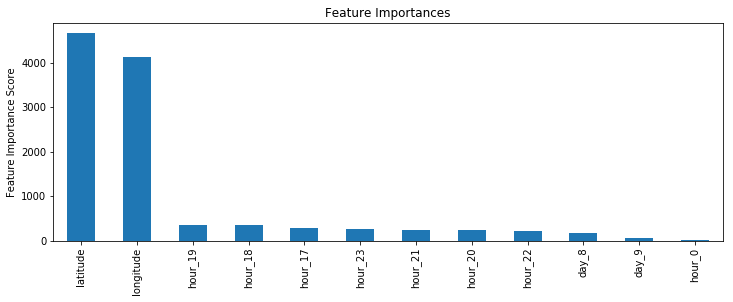

In [51]:
predictors = [x for x in train.columns if x not in [target]]
xgb1 = XGBRegressor(
 max_depth=5,
 learning_rate =1,
 n_estimators=400, 
 silent=False,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, train, predictors)

#### Vamos tentar com 1100 árvores


Model Report
R2 Score : 0.8791
n_estimators: 1100


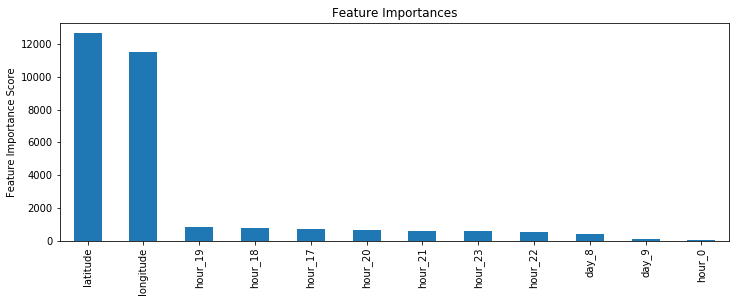

In [52]:
predictors = [x for x in train.columns if x not in [target]]
xgb1 = XGBRegressor(
 max_depth=5,
 learning_rate =1,
 n_estimators=1100, 
 silent=False,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, train, predictors)

## Tunning de parâmetros

In [12]:
predictors = [x for x in train.columns if x not in [target]]
param_test1 = {
 'n_estimators':range(300,1101,200),
 'learning_rate':[i/10.0 for i in range(5,16, 2)]    
}
gsearch1 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=80, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='r2',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.82738, std: 0.00238, params: {'n_estimators': 300, 'learning_rate': 0.5},
  mean: 0.83823, std: 0.00208, params: {'n_estimators': 500, 'learning_rate': 0.5},
  mean: 0.84324, std: 0.00192, params: {'n_estimators': 700, 'learning_rate': 0.5},
  mean: 0.84647, std: 0.00189, params: {'n_estimators': 900, 'learning_rate': 0.5},
  mean: 0.84829, std: 0.00193, params: {'n_estimators': 1100, 'learning_rate': 0.5},
  mean: 0.82929, std: 0.00193, params: {'n_estimators': 300, 'learning_rate': 0.7},
  mean: 0.83748, std: 0.00183, params: {'n_estimators': 500, 'learning_rate': 0.7},
  mean: 0.84119, std: 0.00166, params: {'n_estimators': 700, 'learning_rate': 0.7},
  mean: 0.84369, std: 0.00148, params: {'n_estimators': 900, 'learning_rate': 0.7},
  mean: 0.84479, std: 0.00148, params: {'n_estimators': 1100, 'learning_rate': 0.7},
  mean: 0.82568, std: 0.00241, params: {'n_estimators': 300, 'learning_rate': 0.9},
  mean: 0.83286, std: 0.00189, params: {'n_estimators': 500, 'learning_rat

### n_estimators:1100

Como o melhor learning rate foi o menor da lista, vou tentar com valores menores que ele para tentar conseguir mais ganho

In [13]:
predictors = [x for x in train.columns if x not in [target]]
param_test1 = {
 'learning_rate':[i/10.0 for i in range(1,6, 2)]    
}
gsearch1 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=1100, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='r2',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.81918, std: 0.00244, params: {'learning_rate': 0.1},
  mean: 0.84609, std: 0.00125, params: {'learning_rate': 0.3},
  mean: 0.84829, std: 0.00193, params: {'learning_rate': 0.5}],
 {'learning_rate': 0.5},
 0.8482913859111264)

O melhor learning_rate continou sendo o 0.5

### learning_rate:0.5

In [10]:
param_test1 = {
 'max_depth':range(5,7,1),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.5, n_estimators=1100, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='r2',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_ 

([mean: 0.84829, std: 0.00193, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.84839, std: 0.00192, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.84830, std: 0.00216, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.85407, std: 0.00183, params: {'max_depth': 6, 'min_child_weight': 1},
  mean: 0.85398, std: 0.00154, params: {'max_depth': 6, 'min_child_weight': 3},
  mean: 0.85378, std: 0.00158, params: {'max_depth': 6, 'min_child_weight': 5}],
 {'max_depth': 6, 'min_child_weight': 1},
 0.8540707714670711)

### min_child_weight:1

In [11]:
predictors = [x for x in train.columns if x not in [target]]
param_test1 = {
 'max_depth':range(6,10,1)
}
gsearch1 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.5, n_estimators=1100, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='r2',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.85407, std: 0.00183, params: {'max_depth': 6},
  mean: 0.85519, std: 0.00132, params: {'max_depth': 7},
  mean: 0.85538, std: 0.00134, params: {'max_depth': 8},
  mean: 0.85319, std: 0.00114, params: {'max_depth': 9}],
 {'max_depth': 8},
 0.8553827492851346)

### max_depth: 8

In [7]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch1 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.5, n_estimators=1100, max_depth=8,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test3, scoring='r2',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.85538, std: 0.00134, params: {'gamma': 0.0},
  mean: 0.85469, std: 0.00124, params: {'gamma': 0.1},
  mean: 0.85471, std: 0.00122, params: {'gamma': 0.2},
  mean: 0.85493, std: 0.00121, params: {'gamma': 0.3},
  mean: 0.85515, std: 0.00119, params: {'gamma': 0.4}],
 {'gamma': 0.0},
 0.8553827492851346)

### gamma: 0.0

In [8]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch1 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.5, n_estimators=1100, max_depth=8,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test4, scoring='r2',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.84418, std: 0.00156, params: {'subsample': 0.6, 'colsample_bytree': 0.6},
  mean: 0.84709, std: 0.00226, params: {'subsample': 0.7, 'colsample_bytree': 0.6},
  mean: 0.84981, std: 0.00133, params: {'subsample': 0.8, 'colsample_bytree': 0.6},
  mean: 0.85193, std: 0.00227, params: {'subsample': 0.9, 'colsample_bytree': 0.6},
  mean: 0.84691, std: 0.00130, params: {'subsample': 0.6, 'colsample_bytree': 0.7},
  mean: 0.85019, std: 0.00181, params: {'subsample': 0.7, 'colsample_bytree': 0.7},
  mean: 0.85298, std: 0.00150, params: {'subsample': 0.8, 'colsample_bytree': 0.7},
  mean: 0.85485, std: 0.00135, params: {'subsample': 0.9, 'colsample_bytree': 0.7},
  mean: 0.84841, std: 0.00156, params: {'subsample': 0.6, 'colsample_bytree': 0.8},
  mean: 0.85175, std: 0.00115, params: {'subsample': 0.7, 'colsample_bytree': 0.8},
  mean: 0.85538, std: 0.00134, params: {'subsample': 0.8, 'colsample_bytree': 0.8},
  mean: 0.85766, std: 0.00133, params: {'subsample': 0.9, 'colsample_bytree'

### subsample: 0.9

### colsample_bytree: 0.9

## Vamos verificar como está o score com os parâmetros que testamos até agora


Model Report
R2 Score : 0.9119


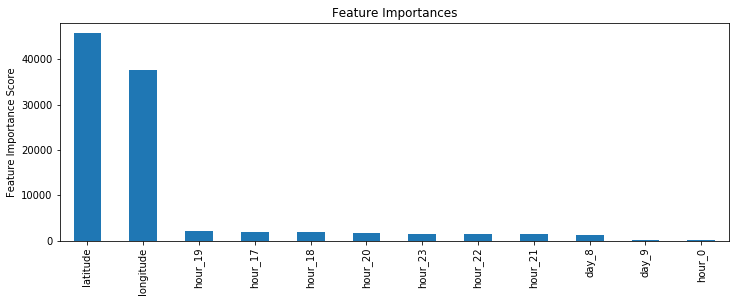

In [10]:
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target]]
xgb1 = XGBRegressor(
 max_depth=8,
 learning_rate =0.5,
 n_estimators=1100, 
 silent=False,
 min_child_weight=1,
 gamma=0,
 subsample=0.9,
 colsample_bytree=0.9,
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, train, predictors)

In [8]:
param_test5 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch1 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.5, n_estimators=1100, max_depth=8,
 min_child_weight=1, gamma=0, subsample=0.9, colsample_bytree=0.9,
 nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test5, scoring='r2',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.85913, std: 0.00101, params: {'reg_alpha': 1e-05},
  mean: 0.85904, std: 0.00103, params: {'reg_alpha': 0.01},
  mean: 0.85912, std: 0.00119, params: {'reg_alpha': 0.1},
  mean: 0.85966, std: 0.00126, params: {'reg_alpha': 1},
  mean: 0.86775, std: 0.00144, params: {'reg_alpha': 100}],
 {'reg_alpha': 100},
 0.8677509191634283)

### reg_alpha: 100

## Agora vamos treinar o modelo com os parâmetros encontrados e verificar o score final contra a base de testes

In [23]:
xgb1 = XGBRegressor(
 max_depth=8,
 learning_rate =0.5,
 n_estimators=1100, 
 silent=False,
 min_child_weight=1,
 gamma=0,
 subsample=0.9,
 colsample_bytree=0.9,
 objective= 'reg:linear',
 reg_alpha=100,
 nthread=4,
 scale_pos_weight=1,
 seed=27)

In [24]:
xgb1.fit(train[predictors], train[target],eval_metric='rmse')

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.9,
       gamma=0, learning_rate=0.5, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=1100, nthread=4,
       objective='reg:linear', reg_alpha=100, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=False, subsample=0.9)

In [25]:
test_predictions = xgb1.predict(test[predictors])

In [26]:
print "R2 Score : %.4g" % metrics.r2_score(y_test, test_predictions)

R2 Score : 0.8713


## O score foi ótimo, mas vamos verificar se a distribuição do erro está próxima de uma distribuição normal

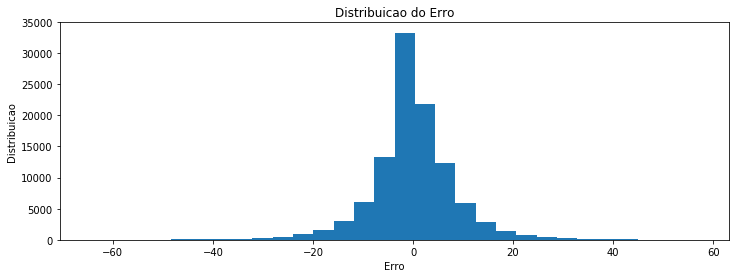

In [30]:
plt.hist(y_test - test_predictions, bins=30)
plt.xlabel('Erro')
plt.ylabel('Distribuicao')
plt.title('Distribuicao do Erro')
plt.show()


#### A distribuição ficou bem próxima de uma distribuição normal e com concentração bem próxima a 0